In [ ]:
## Imports
import numpy as np
import torch
from PIL import Image
import cv2
from torch.nn import functional as F
import einops
from utils.models.factory import create_model_and_transforms, get_tokenizer
from utils.misc.visualization import image_grid, visualization_preprocess
from utils.models.prs_hook import hook_prs_logger    # Logger for applying hook to model
from matplotlib import pyplot as plt
import timm

/home/ggil/anaconda3/envs/MT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ggil/anaconda3/envs/MT/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
## Hyperparameters or chosen model
device = 'cpu'
pretrained = 'laion2b_s34b_b79k'
model_name = 'ViT-B-32' # 'ViT-H-14'
batch_size = 2 # only needed for the nn search
imagenet_path = '/datasets/ilsvrc_2024-01-04_1601/' # only needed for the nn search

In [5]:
## Loading Model
model, _, preprocess = create_model_and_transforms(model_name, pretrained=pretrained)
model.to(device)
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size
tokenizer = get_tokenizer(model_name)   

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model.visual.transformer.resblocks))

prs = hook_prs_logger(model, device) # apply hook to model

{'url': '', 'hf_hub': 'laion/CLIP-ViT-B-32-laion2B-s34B-b79K/', 'mean': None, 'std': None}


/home/ggil/ETHZ/MTWORK2024/MT2024/utils/factory.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_location)


Model parameters: 151,277,313
Context length: 77
Vocab size: 49408
Len of res: 12


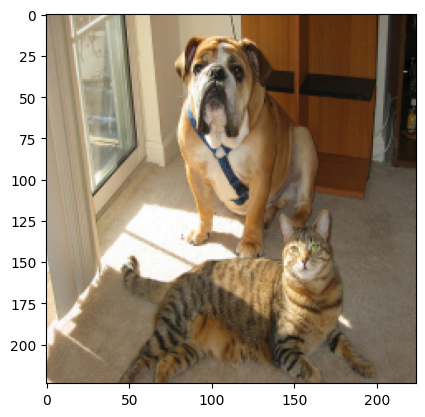

In [6]:
## Load image

image_pil = Image.open('images/catdog.png')
image = preprocess(image_pil)[np.newaxis, :, :, :]
_ = plt.imshow(image_pil)

In [7]:
## Run the image:
prs.reinit()
with torch.no_grad():
    # Get the embedding of the image
    representation = model.encode_image(image.to(device), 
                                        attn_method='head', # get patch contribution per fixed head
                                        normalize=False)
    attentions, mlps = prs.finalize(representation)  # attentions: [1, 12, 197, 16, 512], [b, l, n, h, d], mlps: [1, 13, 512], [b, l + 1, d]
    print(attentions.shape, mlps.shape)

torch.Size([1, 12, 50, 12, 512]) torch.Size([1, 13, 512])


## Visualize token decomposition

In [8]:
## Get the texts
lines = ['An image of a dog', 'An image of a cat']
texts = tokenizer(lines).to(device)  # tokenize text for encoder
class_embeddings = model.encode_text(texts)
#class_embeddings = F.normalize(class_embeddings, dim=-1) # normalize the text embeddings between each other

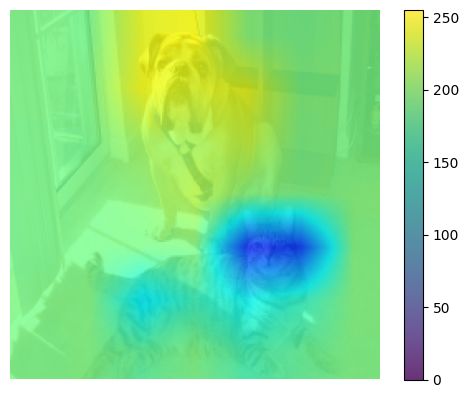

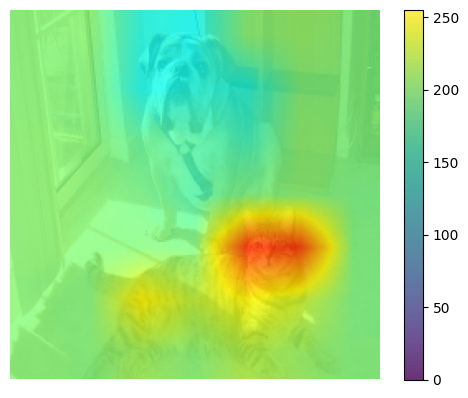

In [14]:
# compose the attention map: group by head, layers and skip the first token to get the total contribution of each the patches
attention_map = attentions[0, :, 1:, :].sum(axis=(0,2)) @ class_embeddings.T # multiply the embedding of each class attrivutes to perform zero-shot segmentation
dim_patch = np.sqrt(attention_map.shape[0]).astype(int)
attention_map = F.interpolate(einops.rearrange(attention_map, '(B N M) C -> B C N M', N=dim_patch, M=dim_patch, B=1), # recompose patches downsample
                                  scale_factor=model.visual.patch_size[0], # scale up if using reduced image size
                                  mode='bilinear').to(device)
attention_map = attention_map[0].detach().cpu().numpy() # get pixeled image map

# Perform min max normalization across classes channel
v_first_class = attention_map[0] - attention_map[1] # np.mean(attention_map,axis=0) # contribution only in direction of first class
v_second_class = attention_map[1] - attention_map[0]

min_ = min((v_first_class).min(), (v_second_class).min()) # get min value per pixel
max_ = max((v_first_class).max(), (v_second_class).max()) # get max value per pixel


# heat map for the first class
v = np.uint8((v_first_class - min_ / (max_-min_))*255)
high = cv2.cvtColor(cv2.applyColorMap(v, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)

_ = plt.imshow(image_pil) # or for bblack background np.zeros_like(high)
# Overlay attention map on top of the image
plt.imshow(high, alpha=0.8)  # Adjust alpha for transparency
plt.colorbar()
plt.axis('off')
plt.show()


# heat map for the second class
v = np.uint8((v_second_class - min_ / (max_-min_))*255)
high = cv2.cvtColor(cv2.applyColorMap(v, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
_ = plt.imshow(image_pil)
# Overlay attention map on top of the image
plt.imshow(high, alpha=0.8)  # Adjust alpha for transparency
plt.colorbar()
plt.axis('off')
plt.show()